Goal is to predict molecular fingerprint that has inhibitory effect (IC50) on Coronavirus protein (*Replicase polyprotein 1ab*).

- IC50 refers to the concentration of a compound that inhibits 50% of a specific biological activity or response

The specific name of target protein is found via Chembl.
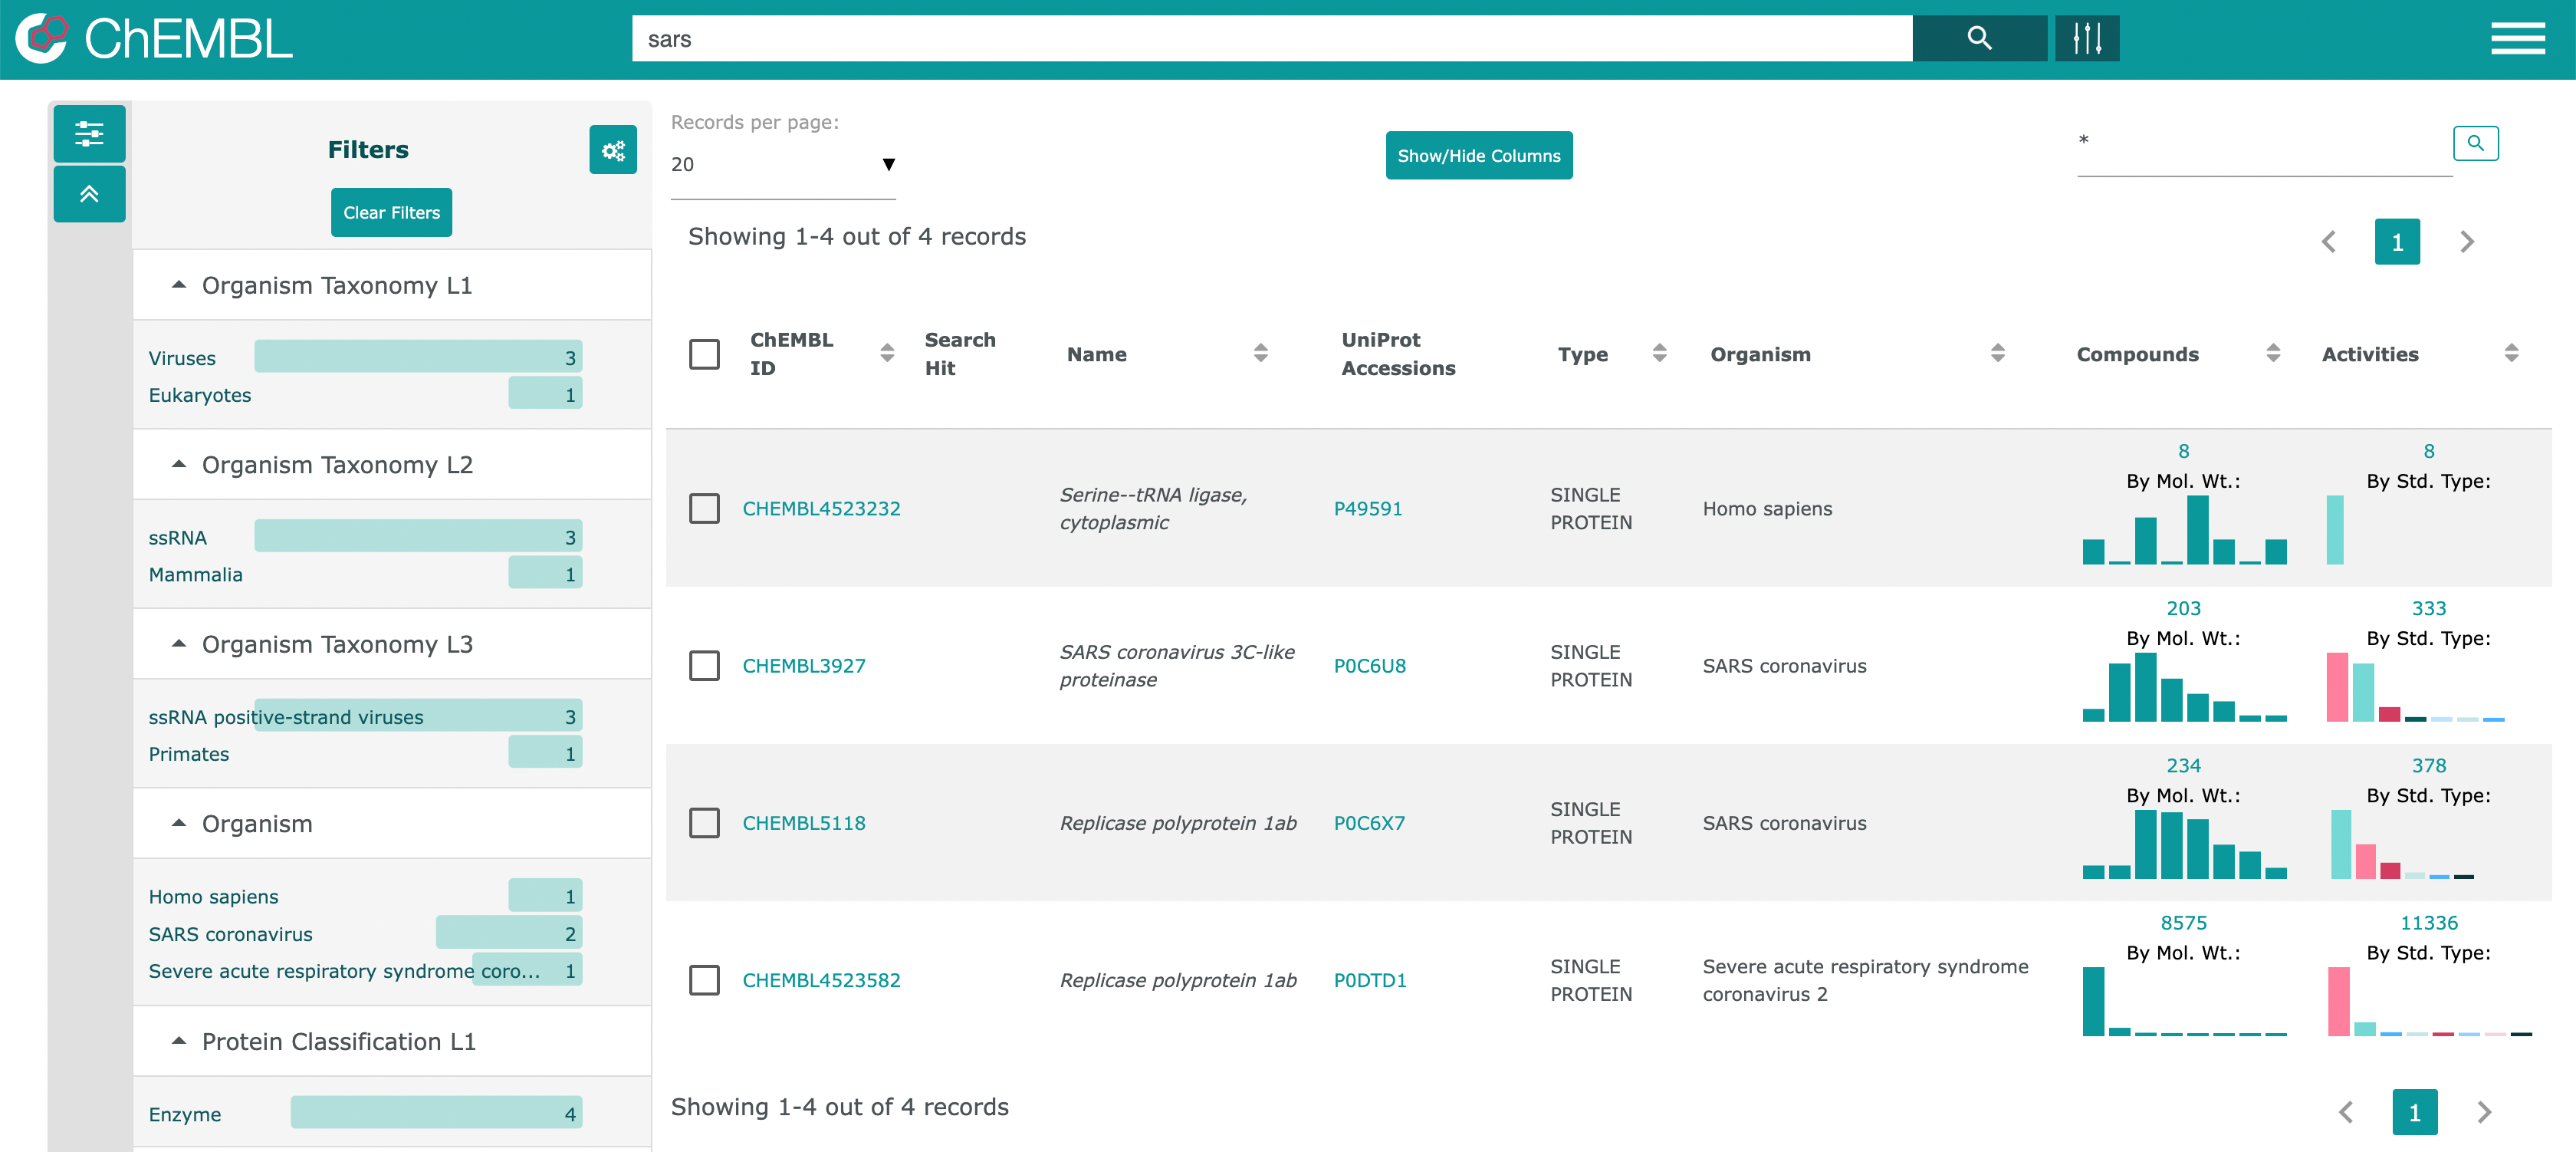

In [84]:
# download PaDEL-Descriptor
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! unzip padel.zip

--2024-07-28 15:04:53--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2024-07-28 15:04:54--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M   116MB/s    in 0.2s    

2024-07-28 15:04:55 (116 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2024-07-28 15:04:55--  https://github

In [1]:
! pip install chembl_webresource_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00


In [1]:
pip install rdkit

In [108]:
from collections import Counter

import pandas as pd
import numpy as np
import lightgbm as lgbm
import xgboost
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Part 1: Get data from Chembl

## Search for target protein & ID from Chembl

In [3]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('P0DTD1')
df_target = pd.DataFrame.from_dict(target_query)
df_target

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,12.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


In [4]:
target_id = df_target['target_chembl_id'].values[0]
target_id

'CHEMBL4523582'

## Search for target protein bioactivity data from Chembl

In [5]:
activity = new_client.activity
search_res = activity.filter(target_chembl_id=target_id).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(search_res)

In [6]:
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,Dtt Insensitive,19964199,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,0.39
1,None,Dtt Insensitive,19964200,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,0.21
2,None,Dtt Insensitive,19964201,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,0.08
3,None,Dtt Insensitive,19964202,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,1.58
4,None,Dtt Insensitive,19964203,[],CHEMBL4495583,SARS-CoV-2 3CL-Pro protease inhibition IC50 de...,F,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25099146,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5260693,Inhibition of MBP tagged recombinant SARS-CoV-...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,0.46
1534,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25099147,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5260694,Inhibition of SARS-CoV-2 RdRP using ATP substr...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,3.22
1535,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25099148,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5260694,Inhibition of SARS-CoV-2 RdRP using ATP substr...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,1.64
1536,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25099151,[],CHEMBL5260697,Inhibition of recombinant SARS-CoV-2 main prot...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,4.7


In [7]:
df.standard_type.unique()

array(['IC50'], dtype=object)

In [8]:
# save raw data
df.to_csv('raw_data-CHEMBL4523582.csv')

# Part 2: Preprocessing

Feature columns:

- `canonical_smiles`: notation represents the chemical information that pertain to the chemical structure

In [46]:
df = pd.read_csv('raw_data-CHEMBL4523582.csv')

## Check nans

Our target column is `standard_value` -- which is the IC50 value.

In [23]:
df.isna().sum()

Unnamed: 0                      0
action_type                   284
activity_comment             1357
activity_id                     0
activity_properties             0
assay_chembl_id                 0
assay_description               0
assay_type                      0
assay_variant_accession      1538
assay_variant_mutation       1538
bao_endpoint                    0
bao_format                      0
bao_label                       0
canonical_smiles                8
data_validity_comment        1519
data_validity_description    1519
document_chembl_id              0
document_journal              117
document_year                   0
ligand_efficiency             308
molecule_chembl_id              0
molecule_pref_name           1308
parent_molecule_chembl_id       0
pchembl_value                 194
potential_duplicate             0
qudt_units                     75
record_id                       0
relation                       75
src_id                          0
standard_flag 

In [47]:
df = df.dropna(subset=['standard_value']).copy()
df['standard_value'] = df['standard_value'].apply(float)

## Filter only for inactive and active compounds

In [48]:
def bioactivity_class(x:float) -> str:
  """ group compounds bioactivity into {active, inactive} based on IC50 concentration
  ie. the amount of a particular inhibitory substance required to interfere with a
  biological process or biological component by 50% in vitro
  """
  # inactive compound (has no effect on target protein at IC50)
  if x >= 10000:
    return 'inactive'
  # active compound (has effect on target protein at IC50)
  if x <= 1000:
    return 'active'


df['target'] = df['standard_value'].apply(bioactivity_class)

In [49]:
Counter(df['target'])

Counter({'active': 766, None: 413, 'inactive': 284})

In [50]:
df = df.dropna(subset=['target', 'canonical_smiles'])

In [51]:
df.isna().sum()

action_type                   151
activity_comment              984
activity_id                     0
activity_properties             0
assay_chembl_id                 0
assay_description               0
assay_type                      0
assay_variant_accession      1045
assay_variant_mutation       1045
bao_endpoint                    0
bao_format                      0
bao_label                       0
canonical_smiles                0
data_validity_comment        1028
data_validity_description    1028
document_chembl_id              0
document_journal               61
document_year                   0
ligand_efficiency             173
molecule_chembl_id              0
molecule_pref_name            919
parent_molecule_chembl_id       0
pchembl_value                 114
potential_duplicate             0
qudt_units                      0
record_id                       0
relation                        0
src_id                          0
standard_flag                   0
standard_relat

### Convert IC50 to the negative log scale $-log_{10}(IC50)$

To make it more uniformly distributed:
- Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by $10^{−9}$
- Take the molar value and apply $-log_{10}$ transformation
- Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
- If the logarithmic value is negative, it will make the interpretation more difficult.

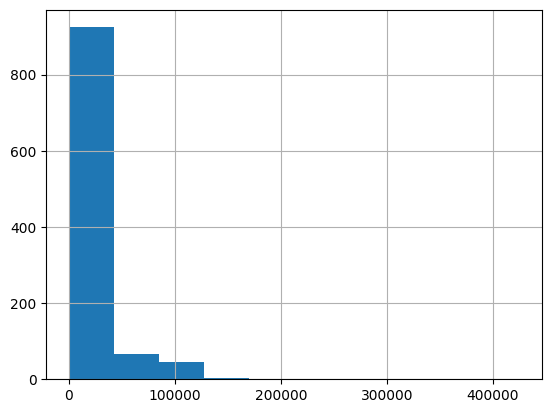

In [52]:
# before - skewed distribution
df['standard_value'].hist();

<Axes: >

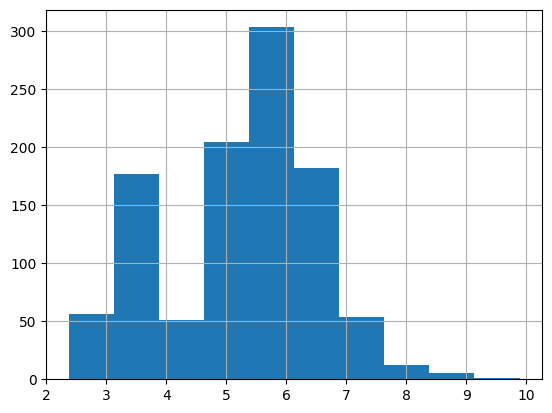

In [53]:
# after - more uniformly distributed
df['standard_value'].apply(lambda x: -np.log10(min(x, 100000000)*10e-9)  ).hist()

In [54]:
df['pIC50'] = df['standard_value'].apply(lambda x: -np.log10(min(x, 100000000)*10e-9))

In [67]:
df = df.reset_index(drop=True)

## Calculate Lipinski descriptors for druglike properties


Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

In [55]:
def lipinski(smiles, verbose=False):
  """Get lipinski descriptors
  ref: https://codeocean.com/explore/capsules?query=tag:data-curation
  """

  moldata= []
  for elem in smiles:
      mol=Chem.MolFromSmiles(elem)
      moldata.append(mol)

  baseData= np.arange(1,1)
  i=0
  for mol in moldata:

      desc_MolWt = Descriptors.MolWt(mol)
      desc_MolLogP = Descriptors.MolLogP(mol)
      desc_NumHDonors = Lipinski.NumHDonors(mol)
      desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

      row = np.array([desc_MolWt,
                      desc_MolLogP,
                      desc_NumHDonors,
                      desc_NumHAcceptors])

      if(i==0):
          baseData=row
      else:
          baseData=np.vstack([baseData, row])
      i=i+1

  columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
  descriptors = pd.DataFrame(data=baseData,columns=columnNames)

  return descriptors

In [68]:
df_lip = lipinski(df['canonical_smiles'])
df_lip

,MW,LogP,NumHDonors,NumHAcceptors
0,369.368,3.51522,1.0,4.0
1,226.351,3.30451,0.0,5.0
2,334.400,3.26220,0.0,5.0
3,237.052,2.22770,0.0,2.0
4,209.252,2.55240,2.0,3.0
...,...,...,...,...
1040,485.507,0.99368,3.0,5.0
1041,507.657,0.50048,3.0,6.0
1042,499.534,1.38378,3.0,5.0
1043,535.589,0.85788,3.0,6.0


In [71]:
dfm = pd.concat([df[['molecule_chembl_id', 'canonical_smiles', 'pIC50', 'target']], df_lip], axis=1)

## Statistical Analysis Mann-Whitney U Test

In [76]:
def mannwhitney(df_2class:pd.DataFrame, descriptor:str, target_col:str, verbose=False):
  """ Check statistical significance of the differences
  ref: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  """
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, target_col]
  df = df_2class[selection]
  active = df[df[target_col] == 'active']
  active = active[descriptor]

  selection = [descriptor, target_col]
  df = df_2class[selection]
  inactive = df[df[target_col] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  # filename = 'mannwhitneyu_' + descriptor + '.csv'
  # results.to_csv(filename)

  return results

In [78]:
mannwhitney(dfm, 'pIC50', target_col='target')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,216124.0,7.758663e-137,0.05,Different distribution (reject H0)


In [79]:
# both active and inactive compounds have similar MW, so it might be a weak feature
mannwhitney(dfm, 'MW', target_col='target')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,108750.5,0.874052,0.05,Same distribution (fail to reject H0)


In [80]:
mannwhitney(dfm, 'LogP', target_col='target')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,81840.0,1.528186e-09,0.05,Different distribution (reject H0)


In [82]:
mannwhitney(dfm, 'NumHDonors', target_col='target')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,121405.0,0.001754,0.05,Different distribution (reject H0)


In [83]:
mannwhitney(dfm, 'NumHAcceptors', target_col='target')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,107795.5,0.950471,0.05,Same distribution (fail to reject H0)


#### Mann-Whitney U Test Findings
2 out of 4 lipinski descriptors show same distribution between active and inactive compounds at IC50.

## Calculate molecular descriptors using PaDEL

In [85]:
dfm

,molecule_chembl_id,canonical_smiles,pIC50,target,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL480,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,5.408935,active,369.368,3.51522,1.0,4.0
1,CHEMBL178459,Cc1c(-c2cnccn2)ssc1=S,5.677781,active,226.351,3.30451,0.0,5.0
2,CHEMBL3545157,O=c1sn(-c2cccc3ccccc23)c(=O)n1Cc1ccccc1,6.096910,active,334.400,3.26220,0.0,5.0
3,CHEMBL4303595,O=C1C=Cc2cc(Br)ccc2C1=O,6.397940,active,237.052,2.22770,0.0,2.0
4,CHEMBL55400,Nc1ccc2cc3ccc(N)cc3nc2c1,5.443697,active,209.252,2.55240,2.0,3.0
...,...,...,...,...,...,...,...,...
1040,CHEMBL5283975,CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1[C@@H]2CC[...,6.262489,active,485.507,0.99368,3.0,5.0
1041,CHEMBL5266964,CC(C)(C)[C@H](NS(=O)(=O)C1CC1)C(=O)N1C[C@H]2[C...,6.641494,active,507.657,0.50048,3.0,6.0
1042,CHEMBL5286307,CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1[C@@H]2CCC...,6.743282,active,499.534,1.38378,3.0,5.0
1043,CHEMBL5282079,CC(C)(C)[C@H](NS(=O)(=O)C(F)(F)F)C(=O)N1C[C@H]...,6.649364,active,535.589,0.85788,3.0,6.0


### Prepare txt file to calc molecular descriptors

In [86]:
dfm[['canonical_smiles', 'molecule_chembl_id']].to_csv('molecule.smi', sep='\t', index=False, header=False)

### Calculate PaDEL descriptors
- `-removesalt`: remove salts eg sodium, chloride which are in the checmial structure. Also remove small organic acids. (we are cleaning the chemical structure so that it has no impurities)
- `-standardizenitro`: also cleans the chemical structure
- `-fingerprints`: option to calculate the molecular fingerprints
- `./PaDEL-Descriptor/PubchemFingerprinter.xml`: specifies that the fingerprint type is pubchem fingerprint
- `-file descriptors_output.csv`: specify the path to output the file

In [87]:
! cat padel.sh


java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [88]:

! bash padel.sh

Processing CHEMBL178459 in molecule.smi (2/1045). 
Processing CHEMBL480 in molecule.smi (1/1045). 
Processing CHEMBL3545157 in molecule.smi (3/1045). Average speed: 3.49 s/mol.
Processing CHEMBL4303595 in molecule.smi (4/1045). Average speed: 2.31 s/mol.
Processing CHEMBL55400 in molecule.smi (5/1045). Average speed: 1.83 s/mol.
Processing CHEMBL1886408 in molecule.smi (6/1045). Average speed: 1.57 s/mol.
Processing CHEMBL505670 in molecule.smi (7/1045). Average speed: 1.37 s/mol.
Processing CHEMBL460499 in molecule.smi (8/1045). Average speed: 1.24 s/mol.
Processing CHEMBL1096979 in molecule.smi (9/1045). Average speed: 1.07 s/mol.
Processing CHEMBL164 in molecule.smi (10/1045). Average speed: 0.97 s/mol.
Processing CHEMBL284861 in molecule.smi (12/1045). Average speed: 0.88 s/mol.
Processing CHEMBL1422849 in molecule.smi (11/1045). Average speed: 0.88 s/mol.
Processing CHEMBL3963349 in molecule.smi (13/1045). Average speed: 0.84 s/mol.
Processing CHEMBL3797437 in molecule.smi (14/104

In [89]:
df_desc = pd.read_csv('descriptors_output.csv')
df_desc = df_desc.drop(columns=['Name'])

In [96]:
df_desc

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1041,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1042,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1043,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [97]:
df_final = pd.concat([df_desc, dfm.drop(columns=['molecule_chembl_id','canonical_smiles', 'target'])], axis=1)
df_final

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5.408935,369.368,3.51522,1.0,4.0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5.677781,226.351,3.30451,0.0,5.0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,6.096910,334.400,3.26220,0.0,5.0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,6.397940,237.052,2.22770,0.0,2.0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5.443697,209.252,2.55240,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,6.262489,485.507,0.99368,3.0,5.0
1041,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,6.641494,507.657,0.50048,3.0,6.0
1042,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,6.743282,499.534,1.38378,3.0,5.0
1043,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,6.649364,535.589,0.85788,3.0,6.0


In [98]:
df_final.to_csv('preprocessed-CHEMBL4523582.csv', index=False)

## Split train test

In [101]:
X = df_final.drop(columns=['pIC50'])
y = df_final['pIC50']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [105]:
X_train

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,MW,LogP,NumHDonors,NumHAcceptors
145,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,593.681,2.4330,4.0,8.0
590,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,472.542,0.8934,5.0,6.0
482,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,475.590,0.9000,5.0,5.0
251,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,511.987,5.0218,0.0,8.0
630,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,507.541,-2.7939,4.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,272.691,3.4355,1.0,3.0
763,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,500.596,1.0383,3.0,6.0
835,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,502.612,1.6782,4.0,6.0
559,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,231.276,2.7043,0.0,4.0


In [106]:
y_train

145     5.174003
590     8.568636
482     5.764472
251     3.557520
630     5.721246
          ...   
1033    5.698970
763     5.080922
835     7.070581
559     5.309804
684     6.017729
Name: pIC50, Length: 836, dtype: float64

# Part 3: Train & evaluate models

### Bayesian Ridge

In [110]:

reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

BayesianRidge()

In [116]:
ypred_br = reg.predict(X_test)
print('BayesianRidge R2:', r2_score(y_test, ypred_br))

BayesianRidge R2: 0.547226023366163


### XGBoost

In [122]:
xg = xgboost.XGBRegressor()
xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [123]:
ypred_xg = xg.predict(X_test)
print('XGBoost R2:', r2_score(y_test, ypred_xg))

XGBoost R2: 0.5242040174442164


### LightGBM

In [124]:
lg = lgbm.LGBMRegressor()
lg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 836, number of used features: 435
[LightGBM] [Info] Start training from score 5.239105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor()

In [125]:
ypred_lg = lg.predict(X_test)
print('Lightgbm R2:', r2_score(y_test, ypred_lg))

Lightgbm R2: 0.5988292550409765


# Conclusion

Goal:
- Predict molecular compound's pIC50 on target protein

Target protein:
- Replicase polyprotein 1ab

Organism:
- Severe acute respiratory syndrome coronavirus 2

What we have achieved:
- Scrape for protein of interest & bioactivity data via Chembl API.
- Preprocess to only include {active, inactive} compounds at pIC50 on target protein.
- Calculated Lipinski descriptors for druglike properties.
- Calculated molecular descriptors using PaDEL.
- Perform Mann-Whitney statistical analysis and found 2 out of 4 lipinski descriptors show same distribution between active and inactive compounds at IC50.
- Trained 3 models (Bayesian Ridge, XGBoost, LightGBM), however all of the trained models have subpar performance ~50%.


What could be improved:
- Perform more feature extraction, perhaps using PCA.